In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/card-fraud/fraud_test.csv
/kaggle/input/card-fraud/fraud_train.csv


**This notebook looks into card fraud in today's financial systems.**

In [2]:
data = pd.read_csv('/kaggle/input/card-fraud/fraud_train.csv')
data = data.drop(['index', 'index.1'], axis=1)
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,11.811375,79.911577,3.460003,1.0,0.0,0.0,1.0,1.0
1,16.594812,4.014540,0.040296,1.0,0.0,0.0,1.0,0.0
2,37.006918,0.054806,1.123759,1.0,1.0,0.0,1.0,0.0
3,11.268316,0.010361,0.499666,1.0,1.0,0.0,0.0,0.0
4,7.654132,8.706302,0.237004,1.0,1.0,0.0,1.0,0.0


In [3]:
data_test = pd.read_csv('/kaggle/input/card-fraud/fraud_test.csv')
data_test = data_test.drop(['index'], axis=1)
data_test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,30.502547,0.806004,2.419891,1.0,0.0,0.0,0.0
1,56.335770,16.379259,0.647923,1.0,1.0,0.0,1.0
2,2.455487,0.674429,0.434767,1.0,1.0,0.0,1.0
3,63.999051,0.176765,0.181112,1.0,1.0,0.0,1.0
4,8.347563,8.324068,0.397537,1.0,0.0,1.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              100000 non-null  float64
 1   distance_from_last_transaction  100000 non-null  float64
 2   ratio_to_median_purchase_price  100000 non-null  float64
 3   repeat_retailer                 100000 non-null  float64
 4   used_chip                       100000 non-null  float64
 5   used_pin_number                 100000 non-null  float64
 6   online_order                    100000 non-null  float64
 7   fraud                           100000 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB


**Exploratory Data Analysis**

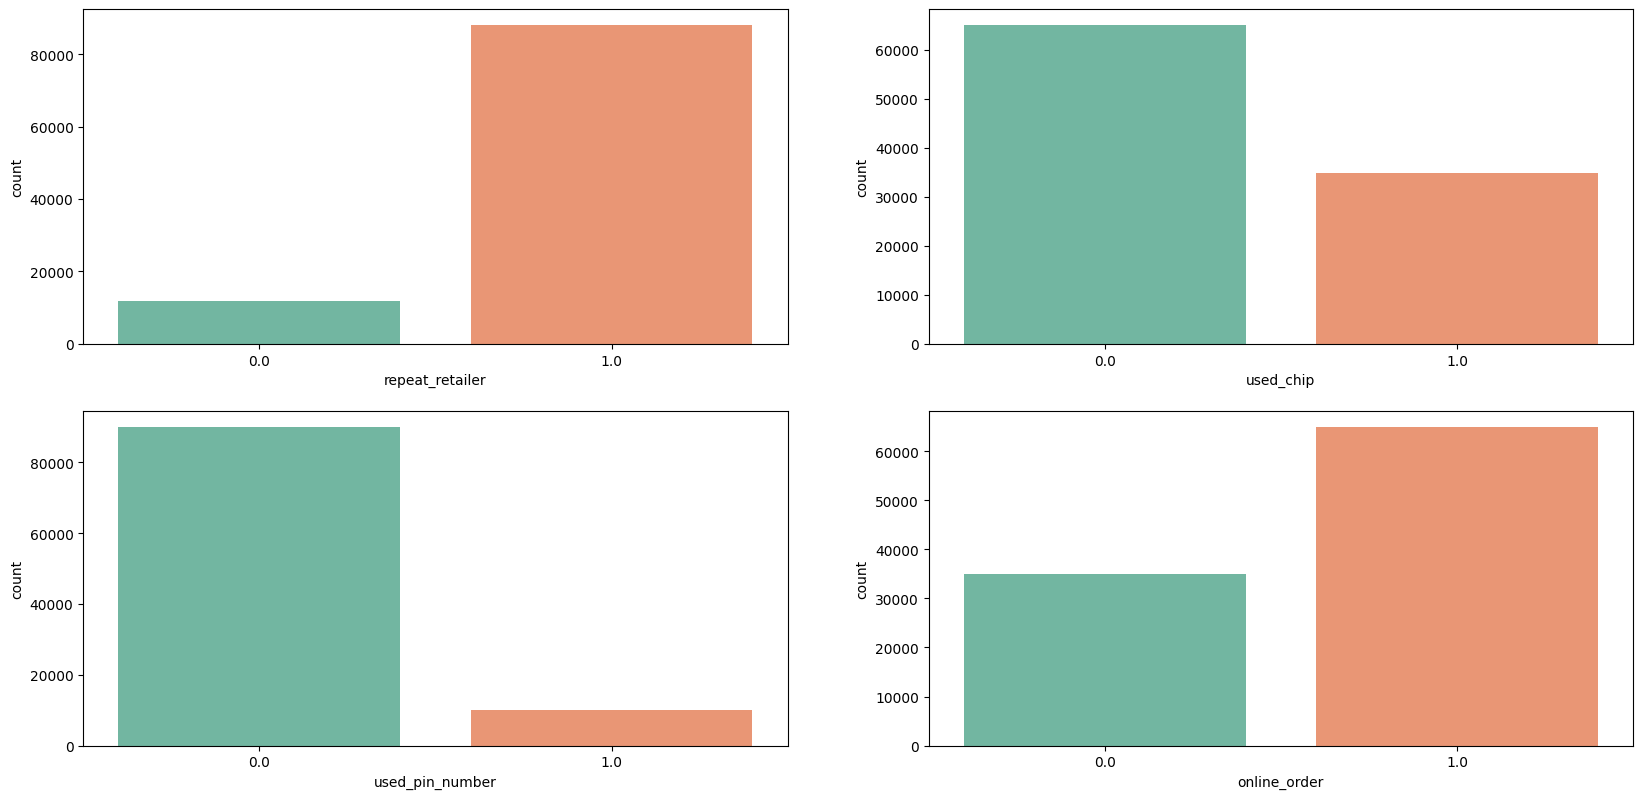

In [17]:
plt.figure(figsize = (20,20))

plt.subplot(4,2,1)
sns.countplot(x = 'repeat_retailer', palette='Set2', data = data)

plt.subplot(4,2,2)
sns.countplot(x = 'used_chip', palette='Set2', data = data)

plt.subplot(4,2,3)
sns.countplot(x = 'used_pin_number', palette='Set2', data = data)

plt.subplot(4,2,4)
sns.countplot(x = 'online_order', palette='Set2', data = data)
plt.savefig('fraud_new_1.png', dpi=300)

**Notes**
* Repeat retailer: Fraud transaction seems to be more common with the same retailer.
* USED CHIP: Genuine transactions that use(i.e card) were more but the fraudulent transactions are not far at about half.
* USED PIN NUMBER: In cases where the a pin is used to authorise a transaction, fraudulent transactions were very minimal
* ONLINE ORDER: Fraudulant transactions were two times more that than gunuine transactions.

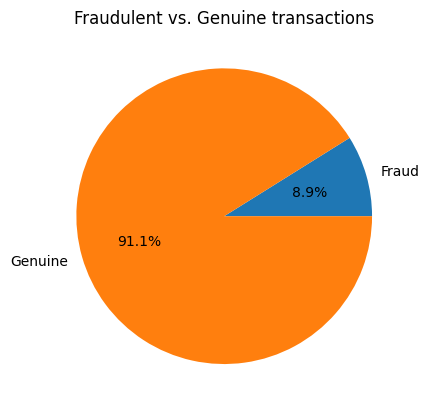

<Figure size 640x480 with 0 Axes>

In [18]:
sizes_1 = data['fraud'].value_counts()[1]
sizes_0 = data['fraud'].value_counts()[0]

plt.pie([sizes_1, sizes_0], labels=['Fraud', 'Genuine'], autopct='%1.1f%%')
plt.title('Fraudulent vs. Genuine transactions')
plt.show()
plt.savefig('fraud_new_pie.png', dpi=300)

**FRAUD: Fraudulent transactions account for 8, 900 of the total 100, 000 transactions in the dataset. Which is 8.9%.**

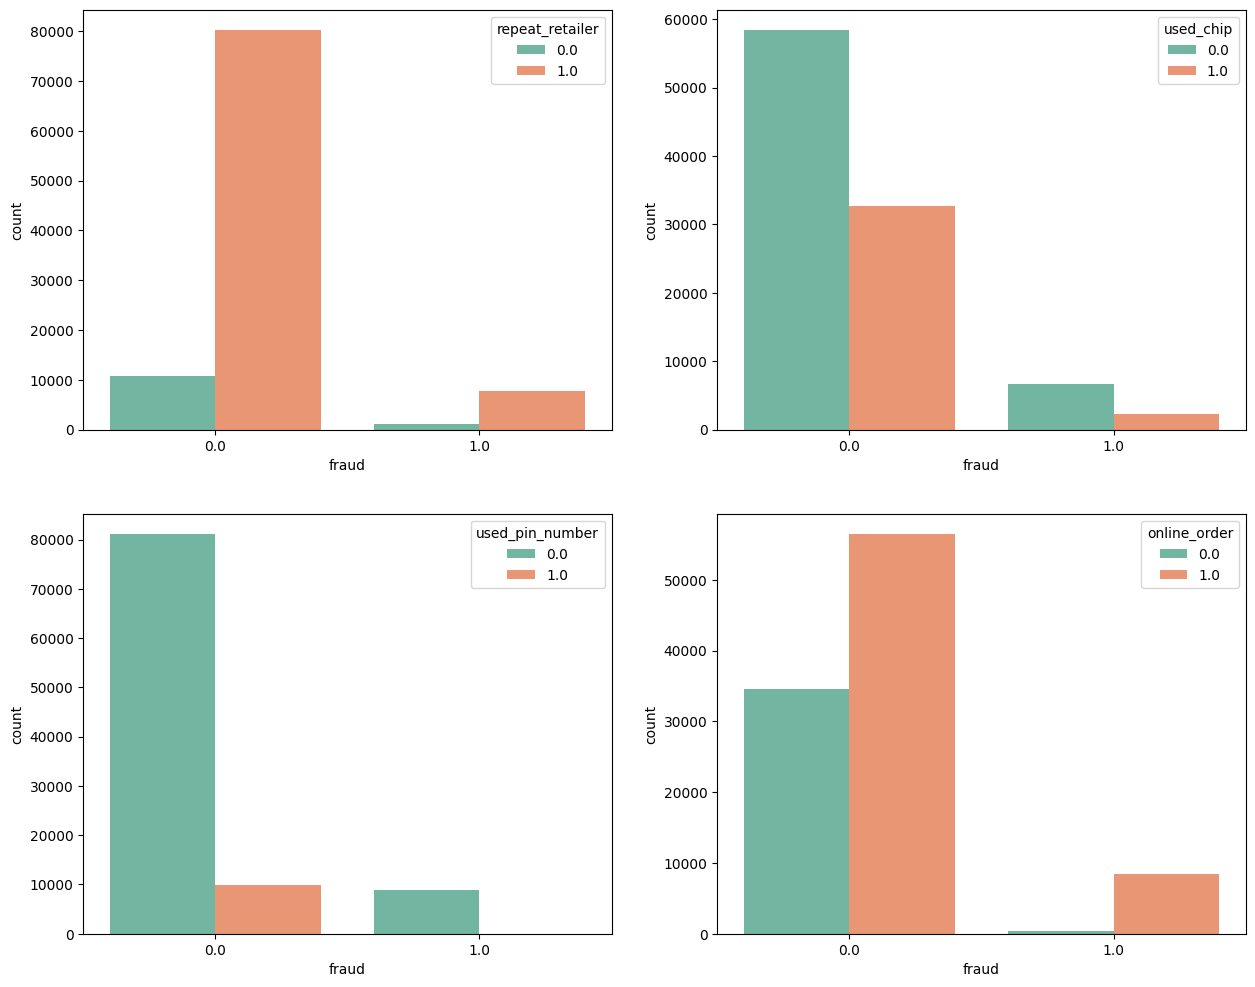

In [19]:
plt.figure(figsize = (15,12))

plt.subplot(2,2,1)
sns.countplot(x = 'fraud', hue= 'repeat_retailer', palette='Set2', data = data)

plt.subplot(2,2,2)
sns.countplot(x = 'fraud', hue= 'used_chip', palette='Set2', data = data)

plt.subplot(2,2,3)
sns.countplot(x = 'fraud', hue= 'used_pin_number', palette='Set2', data = data)

plt.subplot(2,2,4)
sns.countplot(x = 'fraud', hue= 'online_order', palette='Set2', data = data)
plt.savefig('fraud_new_2.png', dpi=300)

**Most of the frauds are in the same retailer in a online purchase, without using the chip and without using the pin**
* Most of the fraud, took place in the same retailer.
* Chip usage in fraud was not significant.
* Usage of PIN was minimal.
* Most of the fraud transaction, took place on online retailers.

**Model Fitting and data prep**

In [8]:
##Split train_test
from sklearn.model_selection import train_test_split
X = data.drop(['fraud'], axis=1)
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


SVM Training and Testing

Now I will try a support vector machine for classification. I simply chose to use a polynomial kernel with a degree of 3.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


model_svm = SVC(C = 1.0, degree = 3, kernel = 'poly')
model_svm.fit(X_train,y_train)
model_svm.score(X_test,y_test)

0.92665

Evaluate the SVM model

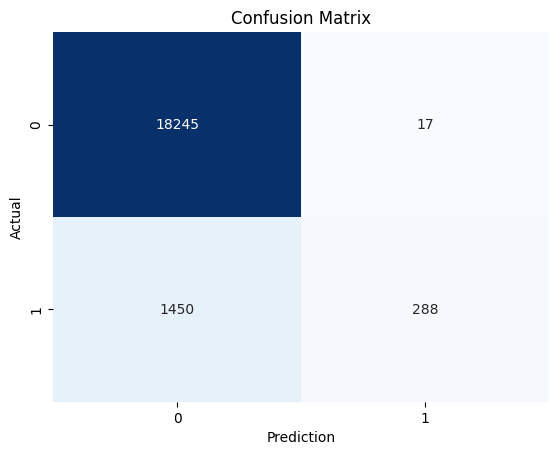

In [10]:
from sklearn.metrics import confusion_matrix

y_pred_svm = model_svm.predict(X_test) 
c_matrix = confusion_matrix(y_test,y_pred_svm)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues', fmt='d')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

**Decision Tree Training and Testing**

Creating and Training the Model

In [11]:
model_dt = DecisionTreeClassifier(max_depth = 8)
model_dt.fit(X_train,y_train)
model_dt.score(X_test,y_test)

0.9998

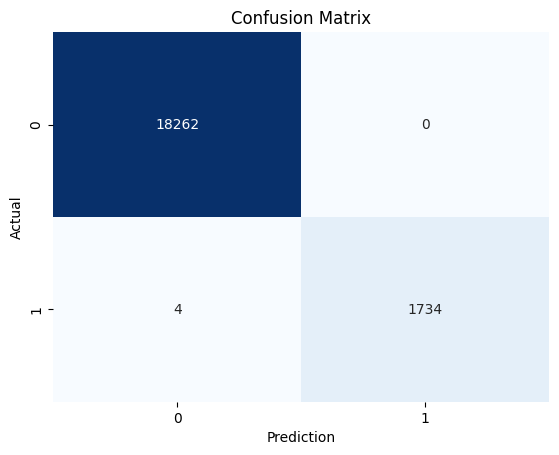

In [12]:
y_pred_dt = model_dt.predict(X_test) 
c_matrix = confusion_matrix(y_test,y_pred_dt)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues', fmt='d')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print("Classification report of SVC\n")
print(classification_report(y_test, y_pred_svm))

Classification report of SVC

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     18262
         1.0       0.94      0.17      0.28      1738

    accuracy                           0.93     20000
   macro avg       0.94      0.58      0.62     20000
weighted avg       0.93      0.93      0.90     20000



In [14]:
print("Classification report of Decision Tree\n")
print(classification_report(y_test, y_pred_dt))

Classification report of Decision Tree

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18262
         1.0       1.00      1.00      1.00      1738

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [15]:
test_preds = model_dt.predict(data_test)
# final = pd.DataFrame(test_preds, index=data_test, columns=['index', 'fraud'])
# final.head
# Assume 'test_preds' is the array of predictions and 'data_test' is the testing dataset
# Get the index values of the testing dataset
test_index = data_test.index.values

# Create a new pandas dataframe with the index and predictions
submission_df = pd.DataFrame({'Index': test_index, 'Fraud': test_preds})
submission_df.head()
# Save the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

**Recommendations and Conclusion**

The numbers might seem small, but with increasing number of online transactions everyday. The amount of fraud grows at the same rate. Here a some the measures we can take to reduce the amount of fraud.

* Find ways of identifying the retailers, with most fraud transactions and help them reduce the numbers.
* Emphasize more on people changing PIN every few months, to avoid PIN theft.
* Look for more policies that can be implemented, that could reduce the amount of fraud on online retailer platforms.
* The online platforms could use Artificial Intelligence, I built a model that was able to detect a 90% of the fraud transactions in the dataset.